This notebook shows the code and use of Fit.py and the class Fit

# Code

In [1]:
# %load ../Code/Fits.py
import Estimation as st
from Histogram import Histogram as hist
from PDF import PDF
import scipy.optimize as sop
import numpy as np
from scipy.special import gammaln
from copy import deepcopy

def generalLogPoisson(x,mu):
    #mu[mu<-2e-11] = np.nan
    return (-mu+x*np.log(mu+0.00001)-gammaln(x+1))

class Fit():
    '''
    Class meant to perform the fit
    '''
    def __init__(self, E, spectrum, PDFs):
        '''
        E: x range (np array) spectrum: experimental points
        PDF: list of spectra PDFs
        nevs: normalizations for the spectra (they are the initial
              values for the fit)
        '''
        self.E = E[:]
        self.spectrum = spectrum.hist[:]
        self.PDFs = deepcopy(PDFs)
        self.PDF_Val = np.array([np.array(pdfi.pdf(E)) for pdfi in self.PDFs])

    def LLh(self, nevs):
        '''
        function meant to compute the LogLikelihood
        '''
        nevs = nevs.reshape(len(nevs),1)
        ypdf = np.sum(nevs*self.PDF_Val,axis=0)
        ydat = self.spectrum
        lm = (np.array(generalLogPoisson(ydat,ypdf))).sum()
        return -2*lm

    def FitLLM(self, nevs, **kwargs):
        '''
        function meant to perform the LogLikelihood fit to data using nevs as
        the initial values
        '''
        nevs = nevs.reshape(len(np.array(nevs)), 1)
        fit = self.LLh
        res = sop.minimize(fit, nevs, method='Nelder-Mead', **kwargs)
        ypdf = np.sum(nevs*self.PDF_Val, axis=0)
        ydat = self.spectrum
        chi2 = -1
        err = -1
        if (res.success):
            chi2 = np.sum((ypdf-ydat)**2/((ydat+0.0001)*(len(ypdf)-len(nevs))))
            err = self.GetError(res.x)
        res.chi2 = chi2
        res.err = err
        return res

    def FitLLMScan(self, nevs, fixn, npoint=100, **kwargs):
        '''
        function meant to return the LogLikelihood profile to data using:
            nevs as the initial values
            fixn as the index of the variable along the profile is made
            npoint as the number of points computed from 0 to 2 times the
                minimim value
        '''
        nevs = nevs.reshape(len(np.array(nevs)), 1)
        aux = nevs[fixn]
        aux_evs = np.delete(nevs, fixn)
        fun_aux = self.FitLLM(nevs, **kwargs).fun
        res_list = np.zeros(2*aux,npoint)
        i = 0
        for aux_s in np.linspace(0, 2*aux,npoint):
            fit = lambda x_nevs: self.LLh(np.insert(x_nevs, fixn,aux_s))
            res = sop.minimize(fit ,aux_evs, method='Nelder-Mead', **kwargs)
            res_list[i] = res.fun-fun_aux
            i += 1
            if not(res.success):
                print('error')
        return np.linspace(0, 2*aux,npoint), res_list

    def GetError(self, nevsmin, **kwargs):
        '''
        function meant to compite the LogLikelihood fit errors using nevsmin as
        the minimum value (fit result)
        '''
        nevs = nevsmin.reshape(len(np.array(nevsmin)),1)
        res_list = np.zeros(len(nevsmin))
        ll_min = self.LLh(nevsmin)
        for fixn in np.arange(len(nevsmin)):
            aux = nevs[fixn]
            aux_evs = np.delete(nevs,fixn)
            fit = lambda aux_s: (lambda x_nevs: self.LLh(np.insert(x_nevs,
                                                                   fixn,
                                                                   aux_s)))
            res = lambda aux_ss: (sop.minimize(fit(aux_ss), aux_evs,
                                               method='Nelder-Mead',
                                               **kwargs)).fun-1-ll_min
            res_list[fixn] = (sop.root(res,aux-aux**0.5).x)[0]
        return nevsmin-res_list


    def GetSpectra(self,E,nevs):
        nevs = np.array(nevs)
        nevs = nevs.reshape(len(nevs), 1)
        ypdf = np.sum(nevs*self.PDF_Val,axis=0)
        return ypdf

    def GetSpectraSQ(self,E,*nevs):
        nevs = np.array(nevs)
        nevs = nevs.reshape(len(nevs), 1)
        ypdf = np.sum(nevs*self.PDF_Val,axis=0)
        return ypdf

    def FitLeastSQ(self,nevs,**kwargs):
        nevs = np.array(nevs)
        nevs = nevs.reshape(len(nevs), 1)
        fit = self.GetSpectraSQ
        res = sop.curve_fit(fit,self.E,self.spectrum, nevs)
        return res


# Using code

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

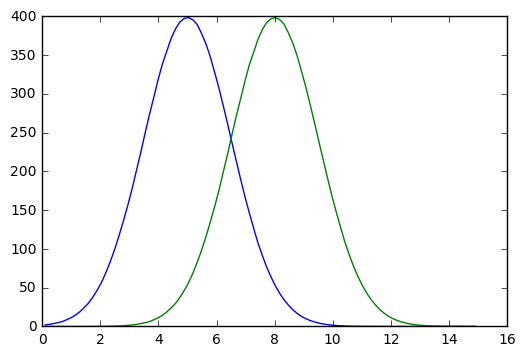

In [3]:
#Creating two gaussian, means 5 and 8 and sigma 1.5, scaling it and ploting it
auxlist = np.random.normal(5,1.5,10000000)
a = hist(auxlist,100,0,15)
b = hist(auxlist+3,100,0,15)
ap = PDF(a,interpolation='linear')
bp = PDF(b,interpolation='linear')

x = np.linspace(0.1,14.9,100)
ya = 10000*ap.pdf(x)
yb = 10000*bp.pdf(x)
plt.plot(x,ya)
plt.plot(x,yb)

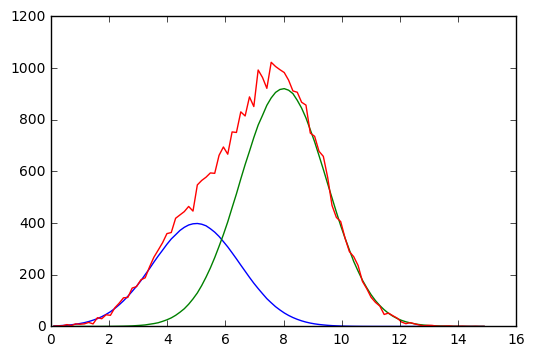

In [4]:
#Building a data set from the two gaussian scaling one and smearing gaussianly. Then data and both gaussians are ploted.
ratio = 2.31
ydata = np.abs(np.random.normal(ya+ratio*yb,np.sqrt(ya+ratio*yb)))
hdata = hist([],100,0,15)
hdata.hist = ydata
hdata.bins = x
plt.plot(x,ya)
plt.plot(x,2.31*yb)
plt.plot(x,ydata)

In [5]:
#Initializing fit class
fit = Fit(x,hdata,[ap,bp]) 

CPU times: user 138 ms, sys: 8.37 ms, total: 147 ms
Wall time: 141 ms
          chi2: 55.067594053168349
           err: array([ 126.16538382,  170.83720754])
 final_simplex: (array([[  9867.91547893,  23201.58771052],
       [  9867.91542321,  23201.58766641],
       [  9867.91542391,  23201.58774348]]), array([ 713.58426305,  713.58426305,  713.58426305]))
           fun: 713.58426305229295
       message: 'Optimization terminated successfully.'
          nfev: 144
           nit: 76
        status: 0
       success: True
             x: array([  9867.91547893,  23201.58771052])


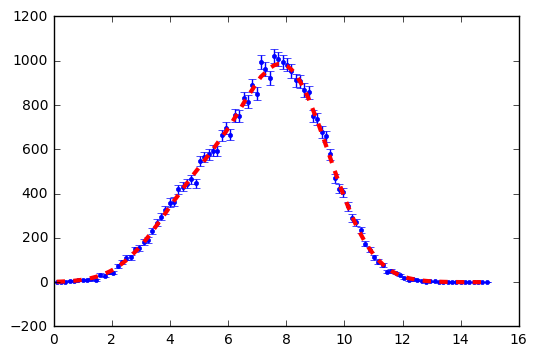

In [6]:
#LL fit and plot
%time res = fit.FitLLM(np.array([1000.,30000.]))
print(res)
yp = fit.GetSpectra(x,res.x)
plt.errorbar(x,ydata,ydata**0.5,marker='.',linestyle='')
plt.plot(x,yp,color='red',linestyle='--',linewidth=3)

CPU times: user 3.44 ms, sys: 0 ns, total: 3.44 ms
Wall time: 2.64 ms
(array([  9843.09157287,  23269.34657848]), array([[ 13088.59702189,  -4823.8133865 ],
       [ -4823.8133865 ,  13096.65176756]]))


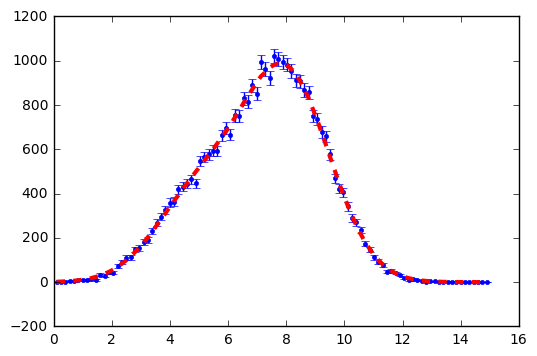

In [7]:
#Least Squares fit and plot
%time res = fit.FitLeastSQ(np.array([100.,100.]),tol=1e-8,options={"maxiter":1000})
print(res)
yp = fit.GetSpectra(x,res[0])
plt.errorbar(x,ydata,ydata**0.5,marker='.',linestyle='')
plt.plot(x,yp,color='red',linestyle='--',linewidth=3)

# Aplication to Spectrum Data
### Take a look to Fitting Spectrum notebook